<a href="https://colab.research.google.com/github/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Cross_Domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment.git@master#egg=multitask_negation_target

In [0]:
from typing import List, Dict
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from multitask_negation_target.analysis import evaluation_metrics
import pandas as pd
import numpy as np

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

ROW_ORDER=['Test', 'Validation']
DATASET_ORDER = ['Laptop', 'Restaurant', 'MAMS']

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def get_data() -> Dict:
  results_df_dict = defaultdict(list)

  base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en/cross_domain'
  model_names = ['STL']
  dataset_names = ['mpqa', 'Restaurant', 'Laptop', 'MAMS']
  split_names = ['Validation', 'Test']
  for model_name in model_names:
    if model_name == 'STL':
      model_url = base_url + '/stl'
    for trained_dataset_name in dataset_names:
      if trained_dataset_name == 'mpqa':
        continue
      for tested_dataset_name in dataset_names:
        if tested_dataset_name == 'mpqa':
          continue
        if trained_dataset_name == tested_dataset_name:
          continue
        for split_name in split_names:
          if split_name == 'Test':
            if trained_dataset_name == 'MAMS':
              result_url = model_url + f'/{trained_dataset_name}/{tested_dataset_name.lower()}/test.conll'
            else:
              result_url = model_url + f'/{trained_dataset_name.lower()}/{tested_dataset_name.lower()}/test.conll'
              if tested_dataset_name == 'MAMS':
                result_url = model_url + f'/{trained_dataset_name.lower()}/{tested_dataset_name}/test.conll'
          elif split_name == 'Validation':
            if trained_dataset_name == 'MAMS':
              result_url = model_url + f'/{trained_dataset_name}/{tested_dataset_name.lower()}/dev.conll'
            else:
              result_url = model_url + f'/{trained_dataset_name.lower()}/{tested_dataset_name.lower()}/dev.conll'
              if tested_dataset_name == 'MAMS':
                result_url = model_url + f'/{trained_dataset_name.lower()}/{tested_dataset_name}/dev.conll'
          for run_number in range(5):
            with tempfile.TemporaryDirectory() as temp_dir:
              temp_fp = Path(temp_dir, 'temp_file.txt')
              with temp_fp.open('w') as temp_file:
                temp_file.write(requests.get(result_url).text)
              f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=True)
              f1_a_recall, f1_a_precision, f1_a = f1_a
              f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False)
              f1_i_recall, f1_i_precision, f1_i = f1_i
              pos_filter_name = 'POS'
              neu_filter_name = 'NEU'
              neg_filter_name = 'NEG'
              #if dataset_name == 'mpqa':
              #  pos_filter_name = 'positive'
              #  neu_filter_name = 'neutral'
              #  neg_filter_name = 'negative'

              f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                    ignore_sentiment=False, 
                                                    filter_by_sentiment=pos_filter_name)
              f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
              f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                    ignore_sentiment=False, 
                                                    filter_by_sentiment=neu_filter_name)
              f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
              f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                    ignore_sentiment=False, 
                                                    filter_by_sentiment=neg_filter_name) 
              f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
              f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                          metric_func=f1_score, 
                                                          average='macro')
              acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                          metric_func=accuracy_score)
              results_df_dict['Model'].append(model_name)
              results_df_dict['Trained Dataset'].append(trained_dataset_name)
              results_df_dict['Tested Dataset'].append(tested_dataset_name)
              results_df_dict['Split'].append(split_name)
              results_df_dict['Run'].append(run_number)
              results_df_dict['F1-a'].append(f1_a)
              results_df_dict['F1-a-R'].append(f1_a_recall)
              results_df_dict['F1-a-P'].append(f1_a_precision)
              results_df_dict['F1-i'].append(f1_i)
              results_df_dict['F1-i-R'].append(f1_i_recall)
              results_df_dict['F1-i-P'].append(f1_i_precision)
              results_df_dict['F1-i-pos'].append(f1_i_pos)
              results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
              results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
              results_df_dict['F1-i-neg'].append(f1_i_neg)
              results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
              results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
              results_df_dict['F1-i-neu'].append(f1_i_neu)
              results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
              results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
              results_df_dict['F1-s'].append(f1_s)
              results_df_dict['Acc-s'].append(acc_s)
  return results_df_dict

# Cross Domain

This uses the CWR models where they have been trained on one of the following datasets:
1. Laptop
2. Restaurant
3. MAMS
4. mpqa

Of which all of them use domain specific CWR apart from mpqa which uses a generic.

In [13]:
results_df = pd.DataFrame(get_data())
not_metric_cols = ['Model', 'Trained Dataset', 'Tested Dataset', 'Split', 'Run']
metric_cols = [col_name for col_name in results_df.columns.tolist() 
               if col_name not in not_metric_cols]
results_df = pd.melt(results_df, id_vars=not_metric_cols, value_vars=metric_cols, 
                     var_name='Metric', value_name='Score')
test_results_df = results_df[results_df['Split']=='Test']
val_results_df = results_df[results_df['Split']=='Validation']
results_df.head()

https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en/cross_domain/stl/restaurant/laptop/dev.conll
https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en/cross_domain/stl/restaurant/laptop/dev.conll
https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en/cross_domain/stl/restaurant/laptop/dev.conll
https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en/cross_domain/stl/restaurant/laptop/dev.conll
https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en/cross_domain/stl/restaurant/laptop/dev.conll
https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en/cross_domain/stl/restaurant/laptop/test.conll
https://raw.githubusercontent.com/jbarnesspain/multitask_

,Model,Trained Dataset,Tested Dataset,Split,Run,Metric,Score
0,STL,Restaurant,Laptop,Validation,0,F1-a,0.184713
1,STL,Restaurant,Laptop,Validation,1,F1-a,0.201893
2,STL,Restaurant,Laptop,Validation,2,F1-a,0.226866
3,STL,Restaurant,Laptop,Validation,3,F1-a,0.210526
4,STL,Restaurant,Laptop,Validation,4,F1-a,0.248485


# F1-i

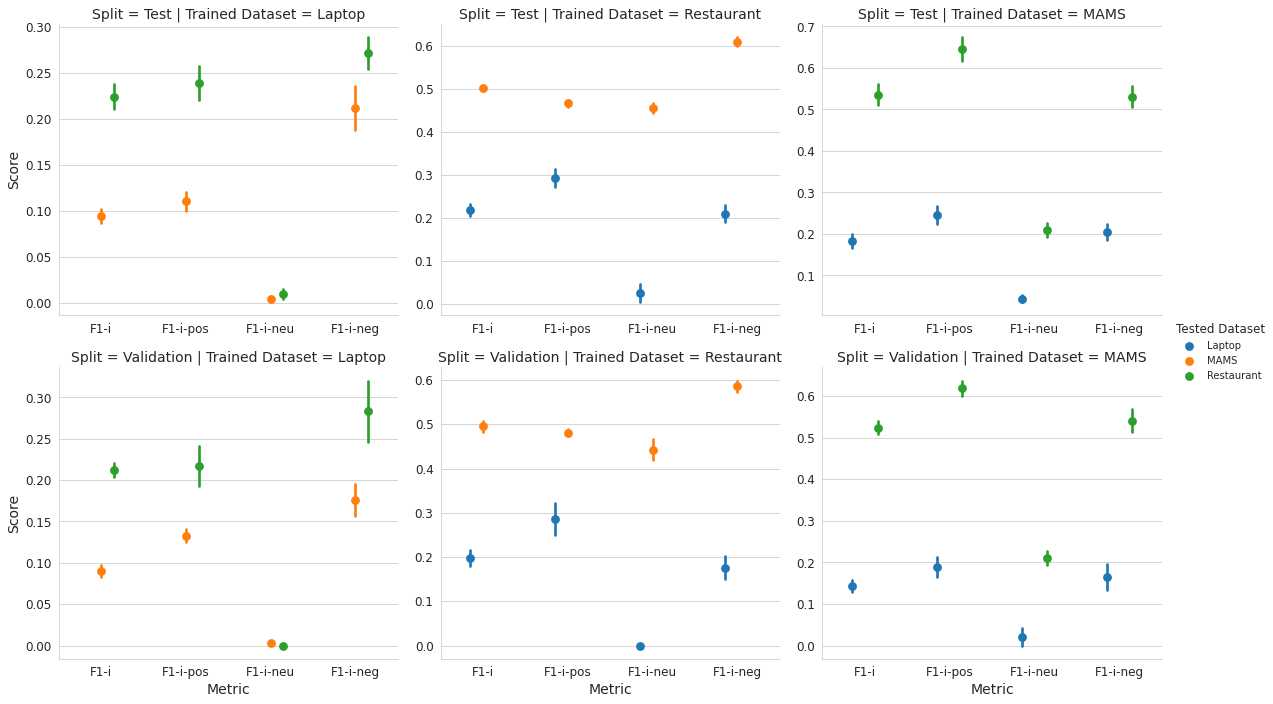

In [27]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = results_df[results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=results_df, hue='Tested Dataset', row='Split', col='Trained Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.3, row_order=ROW_ORDER, 
               col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1)

# F1-a

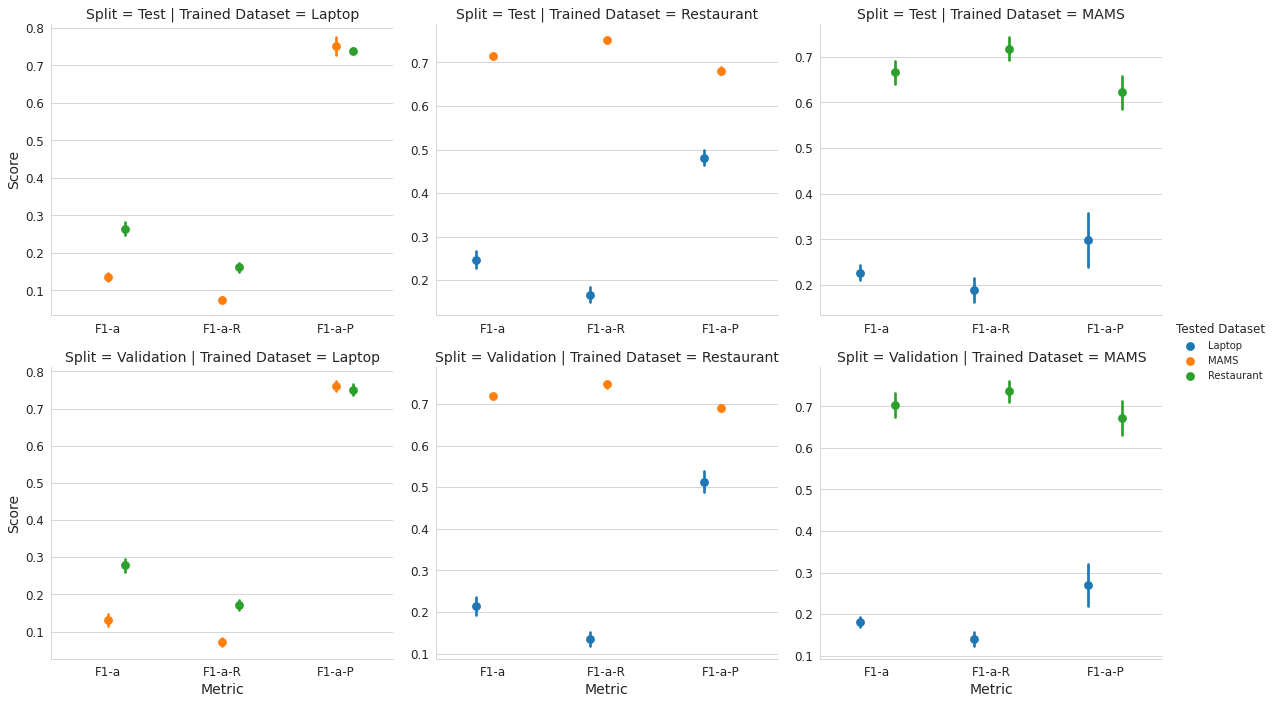

In [28]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = results_df[results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Tested Dataset', row='Split', col='Trained Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.3, row_order=ROW_ORDER, 
               col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1)

# F1-s and Acc-s

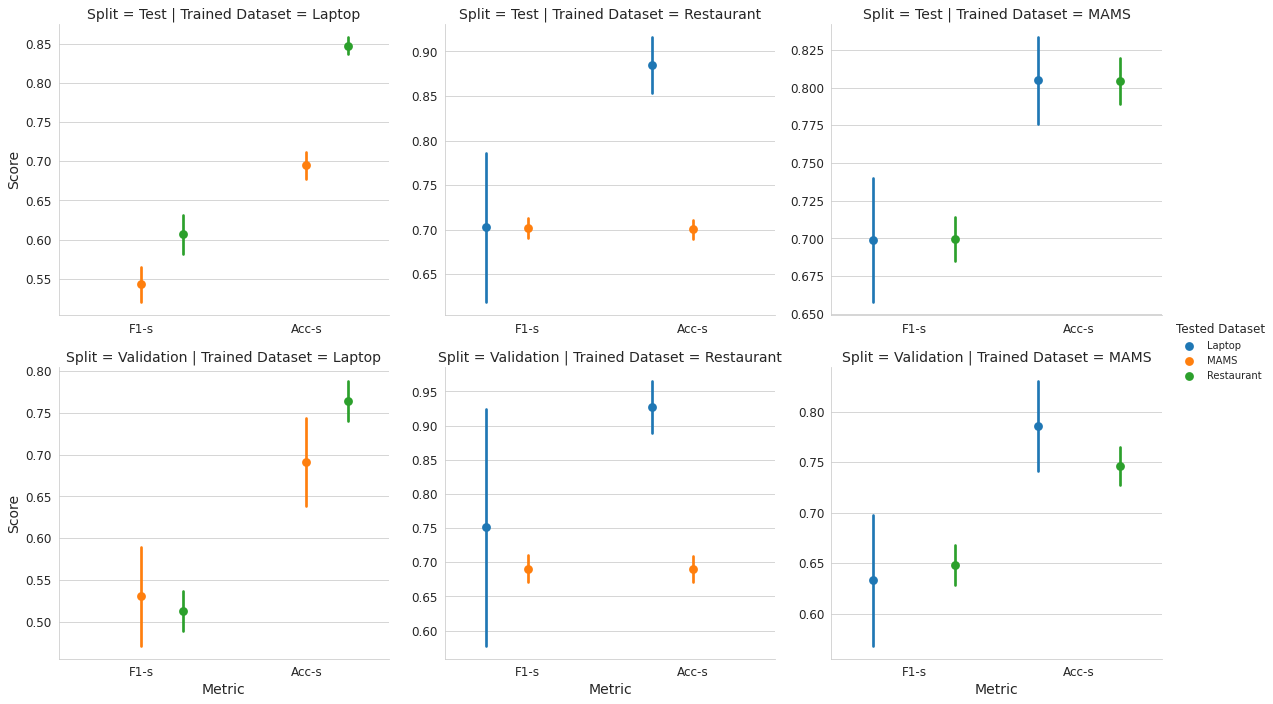

In [29]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = results_df[results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Tested Dataset', row='Split', col='Trained Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1)